In [7]:
# Test autoencoder, sparse autoencoder, deep autoencoder, and variational autoencoder on MNIST datasets 
# Learning and updating code based on Francois Chollet's tutorial code
# Fan Zhang
# 2018-07-13


In [8]:
# from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

# Start from a single fully-connected neural layer as encoder and as decoder:

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [3]:
# maping an input to its encoded representation
encoder = Model(input_img, encoded)

In [4]:
# create a placeholder for an encoded (32-dimensional) input

encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
# First, configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
# MNIST digits
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


In [8]:
# normalize all values between 0 and 1 and 
# we will flatten the 28x28 images into vectors of size 784

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
# train our autoencoder for 50 epochs
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3595 - val_loss: 0.2717
Epoch 2/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2651 - val_loss: 0.2547
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2435 - val_loss: 0.2301
Epoch 4/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2217 - val_loss: 0.2111
Epoch 5/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.2058 - val_loss: 0.1978
Epoch 6/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1944 - val_loss: 0.1882
Epoch 7/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.1859 - val_loss: 0.1809
Epoch 8/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1791 - val_loss: 0.1745
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.1732 - val_loss: 0.1690
Epoch

In [10]:
# After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. 
# We can visualize the reconstructed inputs and the encoded representations.

In [11]:
# encode and decode some digits, taking them from the "test" set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

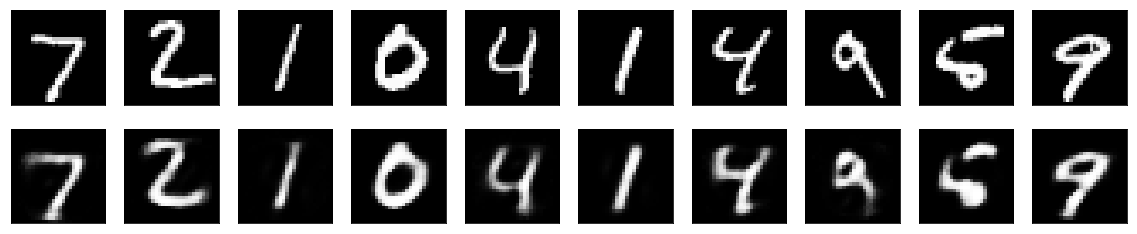

7.2841525

In [22]:
# number of digits we will display
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_imgs.mean() 

In [14]:
# The top row is the original digits, 
# and the bottom row is the reconstructed digits
# We are losing quite a bit of detail with this basic approach.

In [15]:
# Adding a sparsity constraint on the encoded representations

# another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, 
# so fewer units would "fire" at a given time. 
# In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [16]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [18]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.6732 - val_loss: 0.6485
Epoch 2/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.4531 - val_loss: 0.4

In [19]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

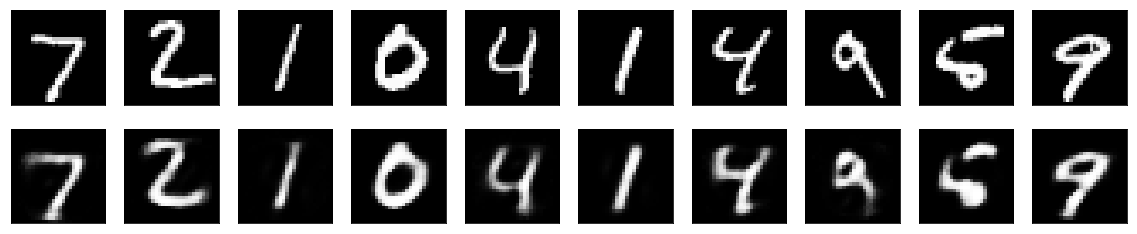

7.2841525

In [23]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_imgs.mean() 

In [24]:
# Deep autoencoder gives better results

In [25]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [27]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs.mean() 

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.0991 - val_loss: 0.0975
Epoch 2/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.0991 - val_loss: 0.0980
Epoch 3/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.0988 - val_loss: 0.0973
Epoch 4/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.0988 - val_loss: 0.0967
Epoch 5/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.0986 - val_loss: 0.0996
Epoch 6/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.0986 - val_loss: 0.0966
Epoch 7/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0983 - val_loss: 0.0993
Epoch 8/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.0983 - val_loss: 0.0983
Epoch 9/100
60000/60000 [==============================] - 3s 51us/step - loss: 0.0980 - val_loss: 0.0

7.2841525

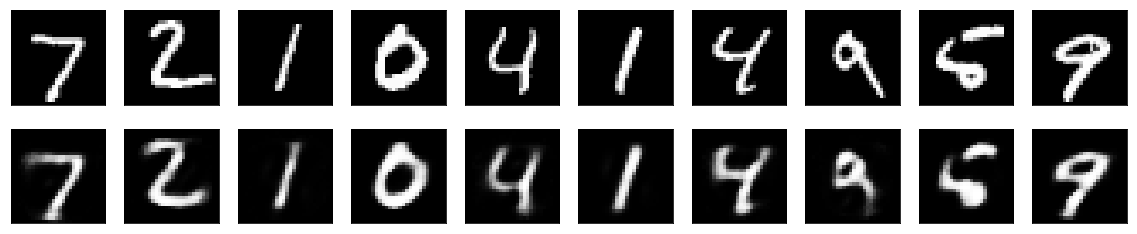

7.2841525

In [28]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_imgs.mean()

In [1]:
# Variational autoencoders (VAE): more advanced

# Instead of learning an arbitrary function, you are learning the parameters of a probability distribution that model your data.
# 1. build up a encoder netework to turn input samples x into a latenet space that has two parameters z_mean and z_log_sigma
# 2. randomly sample similar points z form the latent Gaussian distribtuion to generate the data: z = z_mean + exp(z_log_sigma) * epsilon
# 3. build up a decoder network maps these latenet space points back to the original input data
# Training the model based on two terms:
# Term 1: a loss function between the decoded samples (reconstructed) and the initial inputs
# Term 2: KL divergence between the learned latent distribution and the prior distribution as a regularization term to reduce overfitting to the training data


Using TensorFlow backend.


In [2]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50


In [67]:
# Two functions:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='jet')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()



In [17]:
# Now instantiate 3 models:

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_2[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [22]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [23]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [40]:
# VAE loss = xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss

<tf.Tensor 'Mean_3:0' shape=(?,) dtype=float32>

In [41]:
reconstruction_loss *= original_dim
reconstruction_loss

<tf.Tensor 'mul_1:0' shape=(?,) dtype=float32>

In [45]:
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss

<tf.Tensor 'sub_11:0' shape=(?, 2) dtype=float32>

In [46]:
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss

<tf.Tensor 'Sum_1:0' shape=(?,) dtype=float32>

In [47]:
kl_loss *= -0.5

In [50]:
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [52]:
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [56]:
plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)

In [57]:
# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 152us/step - loss: 197.2886 - val_loss: 171.1682
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 168.1137 - val_loss: 165.9605
Epoch 3/50
60000/60000 [==============================] - 8s 141us/step - loss: 164.4143 - val_loss: 163.4682
Epoch 4/50
60000/60000 [==============================] - 9s 145us/step - loss: 162.1059 - val_loss: 161.7341
Epoch 5/50
60000/60000 [==============================] - 10s 160us/step - loss: 160.4186 - val_loss: 160.1525
Epoch 6/50
60000/60000 [==============================] - 10s 158us/step - loss: 159.0304 - val_loss: 158.8668
Epoch 7/50
60000/60000 [==============================] - 10s 164us/step - loss: 157.7556 - val_loss: 157.7564
Epoch 8/50
60000/60000 [==============================] - 8s 136us/step - loss: 156.6244 - val_loss: 156.7905
Epoch 9/50
60000/60000 [==============================] - 8s 138us/

In [58]:
# Save the weights
vae.save_weights('vae_mlp_mnist.h5')

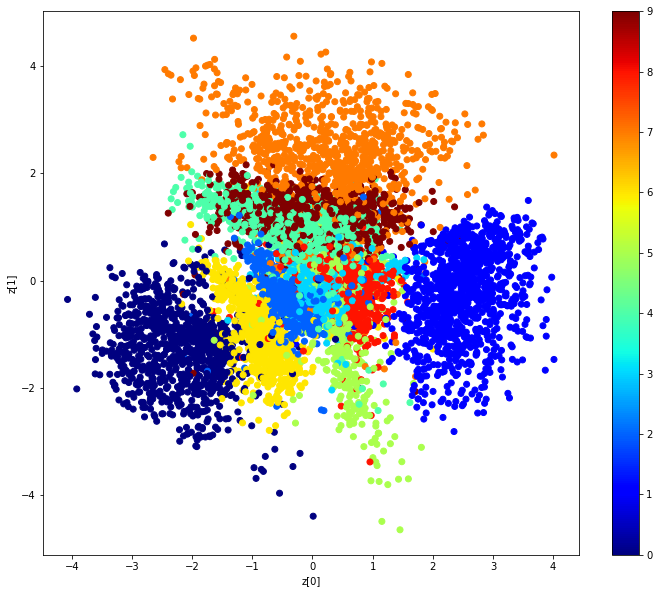

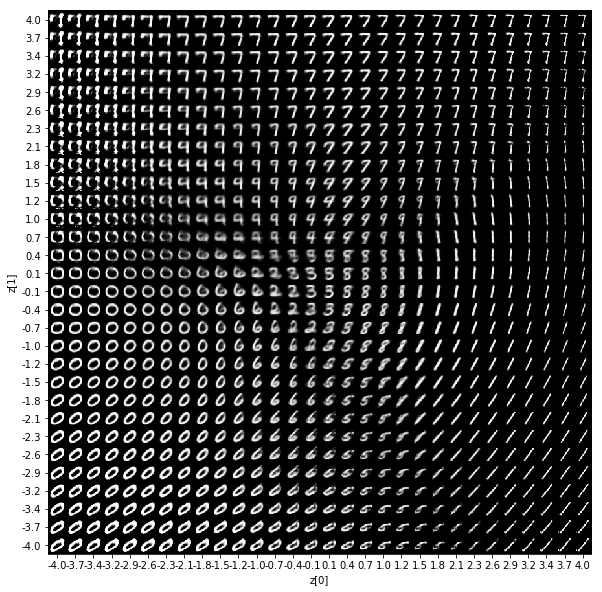

In [68]:
models = (encoder, decoder)
data = (x_test, y_test)

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")